In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [13]:
# Load dataset
df = pd.read_csv("new_file.csv", encoding="ISO-8859-1")

# Clean column names
df.columns = df.columns.str.strip()

# Convert NO2 to numeric and remove invalid values
x = pd.to_numeric(df["no2"], errors="coerce").dropna().values

print("Total samples:", len(x))

Total samples: 188725


/tmp/ipython-input-755/178934187.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("new_file.csv", encoding="ISO-8859-1")


In [34]:
z = x.copy()

In [45]:
low = np.percentile(x, 1)
high = np.percentile(x, 99)

x = x[(x >= low) & (x <= high)]

print("Samples after clipping:", len(x))

Samples after clipping: 181479


In [46]:
scaler = StandardScaler()
z = scaler.fit_transform(x.reshape(-1,1)).astype("float32")

print("Mean:", z.mean())
print("Std:", z.std())

Mean: 3.3632077e-09
Std: 1.0


In [47]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(100,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)   # linear output
    ])
    return model

In [48]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Dense(64, input_shape=(1,)),
        layers.LeakyReLU(0.2),
        layers.Dense(64),
        layers.LeakyReLU(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [42]:
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(
   optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

discriminator.trainable = False

gan_input = layers.Input(shape=(100,))
fake_sample = generator(gan_input)
gan_output = discriminator(fake_sample)

gan = tf.keras.Model(gan_input, gan_output)

gan.compile(
    optimizer=tf.keras.optimizers.Adam(0.0002),
    loss='binary_crossentropy'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
generator = build_generator()
discriminator = build_discriminator()

optimizer = tf.keras.optimizers.Adam(0.0001)

discriminator.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build GAN
discriminator.trainable = False

gan_input = layers.Input(shape=(100,))
fake_sample = generator(gan_input)
gan_output = discriminator(fake_sample)

gan = tf.keras.Model(gan_input, gan_output)

gan.compile(
    optimizer=optimizer,
    loss='binary_crossentropy'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
epochs = 2000
batch_size = 128
half_batch = batch_size // 2

for epoch in range(epochs):

    # ---------------------
    # Train Discriminator
    # ---------------------

    idx = np.random.randint(0, z.shape[0], half_batch)
    real_samples = z[idx]

    noise = np.random.normal(0, 1, (half_batch, 100))
    fake_samples = generator.predict(noise, verbose=0)

    real_labels = np.ones((half_batch, 1))
    fake_labels = np.zeros((half_batch, 1))

    d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)

    # Extract loss value only
    d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])

    # ---------------------
    # Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_labels = np.ones((batch_size, 1))

    g_loss = gan.train_on_batch(noise, valid_labels)

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 | D Loss: 0.7176 | G Loss: 0.7949
Epoch 200 | D Loss: 0.7019 | G Loss: 0.7296
Epoch 400 | D Loss: 0.7065 | G Loss: 0.7194
Epoch 600 | D Loss: 0.7087 | G Loss: 0.7147
Epoch 800 | D Loss: 0.7100 | G Loss: 0.7119
Epoch 1000 | D Loss: 0.7110 | G Loss: 0.7100
Epoch 1200 | D Loss: 0.7118 | G Loss: 0.7085
Epoch 1400 | D Loss: 0.7123 | G Loss: 0.7074
Epoch 1600 | D Loss: 0.7128 | G Loss: 0.7064
Epoch 1800 | D Loss: 0.7132 | G Loss: 0.7056


In [51]:
noise = np.random.normal(0, 1, (10000, 100))
generated_samples = generator.predict(noise).flatten()

print("Real mean:", z.mean(), "Real std:", z.std())
print("Generated mean:", generated_samples.mean(), "Generated std:", generated_samples.std())

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Real mean: 3.3632077e-09 Real std: 1.0
Generated mean: -0.010181619 Generated std: 0.095476925


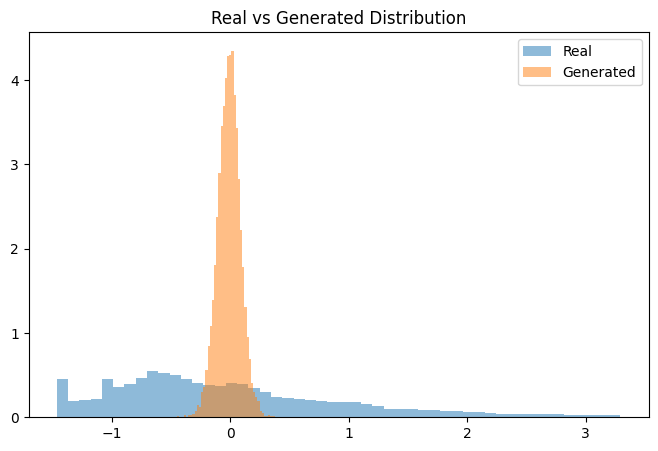

In [52]:
plt.figure(figsize=(8,5))

plt.hist(z.flatten(), bins=50, density=True, alpha=0.5, label="Real")
plt.hist(generated_samples, bins=50, density=True, alpha=0.5, label="Generated")

plt.legend()
plt.title("Real vs Generated Distribution")
plt.show()

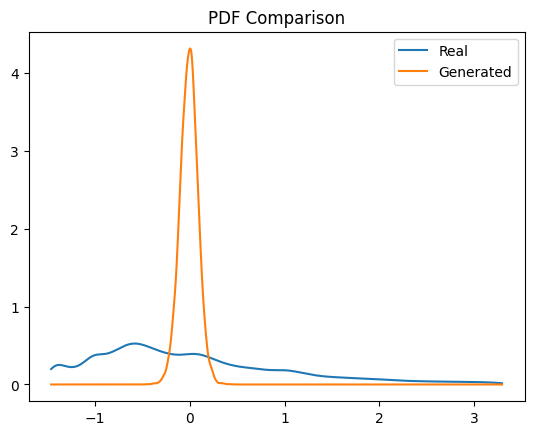

In [53]:
from scipy.stats import gaussian_kde

kde_real = gaussian_kde(z.flatten())
kde_fake = gaussian_kde(generated_samples)

x_range = np.linspace(min(z.min(), generated_samples.min()),
                      max(z.max(), generated_samples.max()), 1000)

plt.plot(x_range, kde_real(x_range), label="Real")
plt.plot(x_range, kde_fake(x_range), label="Generated")
plt.legend()
plt.title("PDF Comparison")
plt.show()